https://uis.fabric-testbed.net/ui/

https://uis.fabric-testbed.net/ui/#/people/people_uuid_get

ssh -i ~/work/fabric_config/pruth_fabric_rsa  -L 2001:localhost:9200  -F ~/work/fabric_config/ssh_config pruth@mfelk-p.fabric-testbed.net

In [154]:
from fabric_reports_client.reports_api import ReportsApi
from datetime import datetime, timezone
import json
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

api =  ReportsApi(base_url="https://reports.fabric-testbed.net:8443/reports", token_file="/Users/kthare10/work/id_token_prod.json")

query_start=None

query_end = datetime.now(timezone.utc)
query_end = query_end.isoformat(timespec='milliseconds')

## Query Projects

In [155]:
print("Query All projects")
projects = api.query_projects(fetch_all=False)
print(f"Total projects: {projects.get('total')}")
print(json.dumps(projects.get("data")[0], indent=4))

Query All projects
Total projects: 172
{
    "project_id": "be352b45-484c-423c-8823-95541bd44e23",
    "project_name": "NakaoLab's Fabric Project",
    "users": {
        "total": 1
    }
}


In [156]:
print("Query All projects in a time range")

# NOTE: If no start time is provided, it will default to 30 days before the end time

projects = api.query_projects(end_time=query_end, fetch_all=False)
print(f"Total projects: {projects.get('total')}")
print(json.dumps(projects.get("data")[0], indent=4))

Query All projects in a time range
Total projects: 171
{
    "project_id": "be352b45-484c-423c-8823-95541bd44e23",
    "project_name": "NakaoLab's Fabric Project",
    "users": {
        "total": 1
    }
}


In [157]:
print("Query All projects using SmartNIC in a time range")
component_type="SmartNIC"
# NOTE: If no start time is provided, it will default to 30 days before the end time
projects = api.query_projects(end_time=query_end, component_type=component_type, fetch_all=False)
print(f"Total projects: {projects.get('total')}")
print(json.dumps(projects.get("data")[0], indent=4))

Query All projects using SmartNIC in a time range
Total projects: 34
{
    "project_id": "6b76128d-c73f-431f-a245-0397586a7d40",
    "project_name": "FABRIC Maintenance",
    "users": {
        "total": 12
    }
}


In [158]:

print("Query All projects using SmartNIC and ConnectX_5 in a time range")
component_type="SmartNIC"
component_model="ConnectX-5"
# NOTE: If no start time is provided, it will default to 30 days before the end time
projects = api.query_projects(end_time=query_end, component_type=component_type, component_model=component_model, fetch_all=False)
print(f"Total projects: {projects.get('total')}")
print(json.dumps(projects.get("data")[0], indent=4))

Query All projects using SmartNIC and ConnectX_5 in a time range
Total projects: 22
{
    "project_id": "6b76128d-c73f-431f-a245-0397586a7d40",
    "project_name": "FABRIC Maintenance",
    "users": {
        "total": 12
    }
}


In [159]:
print("Query project using SmartNIC and ConnectX_5 in a time range for a specific project")
# NOTE: If no start time is provided, it will default to 30 days before the end time
projects = api.query_projects(end_time=query_end, fetch_all=False, project_id="990d8a8b-7e50-4d13-a3be-0f133ffa8653")
print(f"Total projects: {projects.get('total')}")
print(json.dumps(projects.get("data")[0], indent=4))

Query project using SmartNIC and ConnectX_5 in a time range for a specific project
Total projects: 1
{
    "project_id": "990d8a8b-7e50-4d13-a3be-0f133ffa8653",
    "project_name": "FABRIC Staff",
    "users": {
        "data": [
            {
                "slices": {
                    "data": [
                        {
                            "lease_end": "2025-04-06T04:12:33+00:00",
                            "lease_start": "2025-01-18T05:12:34.191000+00:00",
                            "project_id": "990d8a8b-7e50-4d13-a3be-0f133ffa8653",
                            "project_name": "FABRIC Staff",
                            "slice_id": "d3b90221-d35c-4fed-83c4-28366542b152",
                            "slice_name": "RARE-ONIE-1",
                            "slivers": {
                                "total": 4
                            },
                            "state": "Dead",
                            "user_email": "mcevik@email.unc.edu",
                  

## Query Users

In [160]:
print("Query All users")
users = api.query_users(fetch_all=False)
print(f"Total users: {users.get('total')}")
print(json.dumps(users.get("data")[0], indent=4))

Query All users
Total users: 1388
{
    "slices": {
        "total": 6
    },
    "user_email": "cjh8@alfred.edu",
    "user_id": "b92e7b63-c12f-4941-b222-4f4e72c79ea3"
}


In [161]:
print("Query All users in a time range")
# NOTE: If no start time is provided, it will default to 30 days before the end time
users = api.query_users(end_time=query_end, fetch_all=False)
print(f"Total users: {users.get('total')}")
print(json.dumps(users.get("data")[0], indent=4))

Query All users in a time range
Total users: 1376
{
    "slices": {
        "total": 6
    },
    "user_email": "cjh8@alfred.edu",
    "user_id": "b92e7b63-c12f-4941-b222-4f4e72c79ea3"
}


In [162]:
print("Query All users using SmartNIC in a time range")
component_type="SmartNIC"
# NOTE: If no start time is provided, it will default to 30 days before the end time
users = api.query_users(end_time=query_end, component_type=component_type, fetch_all=False)
print(f"Total users: {users.get('total')}")
print(json.dumps(users.get("data")[0], indent=4))

Query All users using SmartNIC in a time range
Total users: 59
{
    "slices": {
        "total": 1573
    },
    "user_email": "mcevik@email.unc.edu",
    "user_id": "42face94-fe57-462f-a747-388680552223"
}


In [163]:

print("Query All users using SmartNIC and ConnectX_5 in a time range")
component_type="SmartNIC"
component_model="ConnectX-5"
# NOTE: If no start time is provided, it will default to 30 days before the end time
users = api.query_users(end_time=query_end, component_type=component_type, component_model=component_model, fetch_all=False)
print(f"Total users: {users.get('total')}")
print(json.dumps(users.get("data")[0], indent=4))

Query All users using SmartNIC and ConnectX_5 in a time range
Total users: 28
{
    "slices": {
        "total": 1573
    },
    "user_email": "mcevik@email.unc.edu",
    "user_id": "42face94-fe57-462f-a747-388680552223"
}


In [164]:
print("Query All users using SmartNIC and ConnectX_5 in a time range for a specific project")
# NOTE: If no start time is provided, it will default to 30 days before the end time
users = api.query_users(end_time=query_end, fetch_all=False, project_id="990d8a8b-7e50-4d13-a3be-0f133ffa8653")
print(f"Total users: {users.get('total')}")
print(json.dumps(users.get("data")[0], indent=4))

Query All users using SmartNIC and ConnectX_5 in a time range for a specific project
Total users: 22
{
    "slices": {
        "data": [
            {
                "lease_end": "2025-04-06T04:12:33+00:00",
                "lease_start": "2025-01-18T05:12:34.191000+00:00",
                "project_id": "990d8a8b-7e50-4d13-a3be-0f133ffa8653",
                "project_name": "FABRIC Staff",
                "slice_id": "d3b90221-d35c-4fed-83c4-28366542b152",
                "slice_name": "RARE-ONIE-1",
                "slivers": {
                    "total": 4
                },
                "state": "Dead",
                "user_email": "mcevik@email.unc.edu",
                "user_id": "42face94-fe57-462f-a747-388680552223"
            },
            {
                "lease_end": "2025-04-06T23:15:14+00:00",
                "lease_start": "2025-03-14T23:15:15.430000+00:00",
                "project_id": "990d8a8b-7e50-4d13-a3be-0f133ffa8653",
                "project_name": "FABR

## Query Slices

In [165]:
print("Query All slices")
slices = api.query_slices(fetch_all=False)
print(f"Total slices: {slices.get('total')}")
print(json.dumps(slices.get("data")[0], indent=4))

Query All slices
Total slices: 89906
{
    "lease_end": "2025-09-02T16:23:08+00:00",
    "lease_start": "2025-03-04T16:23:09.554000+00:00",
    "project_id": "990d8a8b-7e50-4d13-a3be-0f133ffa8653",
    "project_name": "FABRIC Staff",
    "slice_id": "c1d3193b-dba8-4034-bbd8-b179a76f9cf9",
    "slice_name": "sense-82fd12ee-4b3a-4866-b955-318be59e3860",
    "slivers": {
        "total": 1
    },
    "state": "Dead",
    "user_email": "xiyang@es.net",
    "user_id": "3c645ca8-037a-4472-9798-698e985c5155"
}


In [166]:
print("Query All slices in a time range")
# NOTE: If no start time is provided, it will default to 30 days before the end time
slices = api.query_slices(end_time=query_end, fetch_all=False)
print(f"Total slices: {slices.get('total')}")
print(json.dumps(slices.get("data")[0], indent=4))

Query All slices in a time range
Total slices: 6319
{
    "lease_end": "2025-04-17T05:55:27+00:00",
    "lease_start": "2025-04-16T05:55:27.879000+00:00",
    "project_id": "6b76128d-c73f-431f-a245-0397586a7d40",
    "project_name": "FABRIC Maintenance",
    "slice_id": "31422649-6e10-44a5-97c3-024041d35d26",
    "slice_name": "iPerf_23_SEAT_1",
    "slivers": {
        "total": 2
    },
    "state": "Dead",
    "user_email": "kthare10@email.unc.edu",
    "user_id": "43b7271b-90eb-45f6-833a-e51cf13bbc68"
}


In [167]:
print("Query All slices using SmartNIC in a time range")
component_type="SmartNIC"
# NOTE: If no start time is provided, it will default to 30 days before the end time
slices = api.query_slices(end_time=query_end, component_type=component_type, fetch_all=False)
print(f"Total slices: {slices.get('total')}")
print(json.dumps(slices.get("data")[0], indent=4))

Query All slices using SmartNIC in a time range
Total slices: 602
{
    "lease_end": "2025-07-01T16:49:02+00:00",
    "lease_start": "2025-02-17T18:06:30.431000+00:00",
    "project_id": "8e0099fa-e38f-4020-9959-4289039d36bd",
    "project_name": "Ecosystem for Research Networking",
    "slice_id": "8a6f942f-5df5-4dbc-8619-0e73163726b3",
    "slice_name": "frc1",
    "slivers": {
        "total": 3
    },
    "state": "Dead",
    "user_email": "maureen.c.dougherty@rutgers.edu",
    "user_id": "e9db6486-f01a-4284-a3c1-335b17c3a825"
}


In [168]:

print("Query All slices using SmartNIC and ConnectX_5 in a time range")
component_type="SmartNIC"
component_model="ConnectX-5"
# NOTE: If no start time is provided, it will default to 30 days before the end time
slices = api.query_slices(end_time=query_end, component_type=component_type, component_model=component_model, fetch_all=False)
print(f"Total slices: {slices.get('total')}")
print(json.dumps(slices.get("data")[0], indent=4))

Query All slices using SmartNIC and ConnectX_5 in a time range
Total slices: 360
{
    "lease_end": "2025-07-01T16:49:02+00:00",
    "lease_start": "2025-02-17T18:06:30.431000+00:00",
    "project_id": "8e0099fa-e38f-4020-9959-4289039d36bd",
    "project_name": "Ecosystem for Research Networking",
    "slice_id": "8a6f942f-5df5-4dbc-8619-0e73163726b3",
    "slice_name": "frc1",
    "slivers": {
        "total": 3
    },
    "state": "Dead",
    "user_email": "maureen.c.dougherty@rutgers.edu",
    "user_id": "e9db6486-f01a-4284-a3c1-335b17c3a825"
}


In [169]:
print("Query All slices using SmartNIC and ConnectX_5 in a time range for a specific slice")
# NOTE: If no start time is provided, it will default to 30 days before the end time
slices = api.query_slices(end_time=query_end, fetch_all=False, slice_id="f4bfccc3-1360-4148-90c0-b3f21b9240c2")
print(f"Total Slivers: {slices.get('total')}")
print(json.dumps(slices.get("data"), indent=4))

Query All slices using SmartNIC and ConnectX_5 in a time range for a specific slice
Total Slivers: 0
[]


## Query Slivers

In [170]:
print("Query All slivers")
slivers = api.query_slivers(fetch_all=False)
print(f"Total Slivers: {slivers.get('total')}")
print(json.dumps(slivers.get("data")[0], indent=4))

Query All slivers
Total Slivers: 574232
{
    "components": {
        "total": 0
    },
    "interfaces": {
        "total": 2
    },
    "ip_subnet": "None",
    "lease_end": "2025-09-02T16:23:08+00:00",
    "lease_start": "2025-03-04T16:23:09.554000+00:00",
    "project_id": "990d8a8b-7e50-4d13-a3be-0f133ffa8653",
    "project_name": "FABRIC Staff",
    "slice_id": "c1d3193b-dba8-4034-bbd8-b179a76f9cf9",
    "sliver_id": "c9336dec-c731-48e4-8434-bea77dd99628",
    "sliver_type": "l2sts",
    "state": "Closed",
    "user_email": "xiyang@es.net",
    "user_id": "3c645ca8-037a-4472-9798-698e985c5155"
}


In [171]:
print("Query VM slivers in a time range")
# NOTE: If no start time is provided, it will default to 30 days before the end time
slivers = api.query_slivers(end_time=query_end, sliver_type=["VM"], fetch_all=False)
print(f"Total Slivers: {slivers.get('total')}")
print(json.dumps(slivers.get("data")[0], indent=4))

Query VM slivers in a time range
Total Slivers: 16032
{
    "components": {
        "total": 2
    },
    "core": 2,
    "disk": 10,
    "host": "edc-w1.fabric-testbed.net",
    "image": "default_ubuntu_22",
    "interfaces": {
        "total": 0
    },
    "ip_subnet": "None",
    "lease_end": "2025-08-14T20:52:03+00:00",
    "lease_start": "2025-02-13T20:52:04.720000+00:00",
    "project_id": "ac8d64f3-36e1-4a8e-b171-909e0e58b8c0",
    "project_name": "Extensible Internet",
    "ram": 8,
    "site": "EDC",
    "slice_id": "a22cb30b-5752-44ee-aa3c-04ce8b3a7641",
    "sliver_id": "e73922d1-0dcc-4aad-9c46-4b48127f3d98",
    "sliver_type": "vm",
    "state": "Active",
    "user_email": "scauligi@icsi.berkeley.edu",
    "user_id": "bdc77bd9-9886-4f80-ab5e-47b219e6d0cd"
}


In [172]:
print("Query VM slivers in a time range excluding CERN and CIEN")
# NOTE: If no start time is provided, it will default to 30 days before the end time
slivers = api.query_slivers(end_time=query_end, sliver_type=["VM"], 
                            exclude_site=["CERN", "CIEN"], fetch_all=False)
print(f"Total Slivers: {slivers.get('total')}")
print(json.dumps(slivers.get("data")[0], indent=4))

Query VM slivers in a time range excluding CERN and CIEN
Total Slivers: 16032
{
    "components": {
        "total": 2
    },
    "core": 2,
    "disk": 10,
    "host": "edc-w1.fabric-testbed.net",
    "image": "default_ubuntu_22",
    "interfaces": {
        "total": 0
    },
    "ip_subnet": "None",
    "lease_end": "2025-08-14T20:52:03+00:00",
    "lease_start": "2025-02-13T20:52:04.720000+00:00",
    "project_id": "ac8d64f3-36e1-4a8e-b171-909e0e58b8c0",
    "project_name": "Extensible Internet",
    "ram": 8,
    "site": "EDC",
    "slice_id": "a22cb30b-5752-44ee-aa3c-04ce8b3a7641",
    "sliver_id": "e73922d1-0dcc-4aad-9c46-4b48127f3d98",
    "sliver_type": "vm",
    "state": "Active",
    "user_email": "scauligi@icsi.berkeley.edu",
    "user_id": "bdc77bd9-9886-4f80-ab5e-47b219e6d0cd"
}


In [173]:
print("Query All slivers using SmartNIC in a time range")
component_type="SmartNIC"
# NOTE: If no start time is provided, it will default to 30 days before the end time
slivers = api.query_slivers(end_time=query_end, component_type=component_type, fetch_all=False)
print(f"Total Slivers: {slivers.get('total')}")
print(json.dumps(slivers.get("data")[0], indent=4))

Query All slivers using SmartNIC in a time range
Total Slivers: 1646
{
    "components": {
        "total": 3
    },
    "image": "default_rocky_8",
    "interfaces": {
        "total": 0
    },
    "ip_subnet": "None",
    "lease_end": "2025-07-01T16:49:02+00:00",
    "lease_start": "2025-02-17T18:06:30.390000+00:00",
    "project_id": "8e0099fa-e38f-4020-9959-4289039d36bd",
    "project_name": "Ecosystem for Research Networking",
    "site": "RUTG",
    "slice_id": "8a6f942f-5df5-4dbc-8619-0e73163726b3",
    "sliver_id": "aed9ccaf-b4b2-49d0-8b54-d600294533b1",
    "sliver_type": "vm",
    "state": "Closed",
    "user_email": "maureen.c.dougherty@rutgers.edu",
    "user_id": "e9db6486-f01a-4284-a3c1-335b17c3a825"
}


In [174]:

print("Query All slivers using SmartNIC and ConnectX_5 in a time range")
component_type="SmartNIC"
component_model="ConnectX-5"
# NOTE: If no start time is provided, it will default to 30 days before the end time
slivers = api.query_slivers(end_time=query_end, component_type=component_type, component_model=component_model, fetch_all=False)
print(f"Total Slivers: {slivers.get('total')}")
print(json.dumps(slivers.get("data")[0], indent=4))

Query All slivers using SmartNIC and ConnectX_5 in a time range
Total Slivers: 911
{
    "components": {
        "total": 3
    },
    "image": "default_rocky_8",
    "interfaces": {
        "total": 0
    },
    "ip_subnet": "None",
    "lease_end": "2025-07-01T16:49:02+00:00",
    "lease_start": "2025-02-17T18:06:30.390000+00:00",
    "project_id": "8e0099fa-e38f-4020-9959-4289039d36bd",
    "project_name": "Ecosystem for Research Networking",
    "site": "RUTG",
    "slice_id": "8a6f942f-5df5-4dbc-8619-0e73163726b3",
    "sliver_id": "aed9ccaf-b4b2-49d0-8b54-d600294533b1",
    "sliver_type": "vm",
    "state": "Closed",
    "user_email": "maureen.c.dougherty@rutgers.edu",
    "user_id": "e9db6486-f01a-4284-a3c1-335b17c3a825"
}


In [175]:
print("Query All slivers using SmartNIC and ConnectX_5 in a time range for a specific slice")
# NOTE: If no start time is provided, it will default to 30 days before the end time
slivers = api.query_slivers(end_time=query_end, fetch_all=False, slice_id="7975644c-516d-4492-9420-a62010efac2d")
print(f"Total Slivers: {slivers.get('total')}")
print(json.dumps(slivers.get("data"), indent=4))

Query All slivers using SmartNIC and ConnectX_5 in a time range for a specific slice
Total Slivers: 12
[
    {
        "components": {
            "data": [],
            "total": 0
        },
        "interfaces": {
            "data": [
                {
                    "device_name": "gatech-data-sw",
                    "local_name": "HundredGigE0/0/0/2",
                    "name": "server2-server2-nic2-p2"
                },
                {
                    "device_name": "atla-data-sw",
                    "local_name": "HundredGigE0/0/0/0",
                    "name": "switch-switch-nicS2-p1"
                }
            ],
            "total": 2
        },
        "ip_subnet": "None",
        "lease_end": "2025-03-30T15:07:30+00:00",
        "lease_start": "2025-01-13T16:07:31.722000+00:00",
        "project_id": "8eaa3ec2-65e7-49a3-8c09-e1761141a6ad",
        "project_name": "TCP and P4 Programmable Data Plane Switches",
        "slice_id": "7975644c-516d-4492-9420-

# Plots

## Query all Slices

In [184]:
# Step 1: Fetch all slices
response = api.query_slices(fetch_all=True, per_page=1000)
slices = response["data"]
print(f"Total slices: {response.get('total')}")
print(json.dumps(slices[0], indent=4))

Total slices: 89906
{
    "lease_end": "2025-09-02T16:23:08+00:00",
    "lease_start": "2025-03-04T16:23:09.554000+00:00",
    "project_id": "990d8a8b-7e50-4d13-a3be-0f133ffa8653",
    "project_name": "FABRIC Staff",
    "slice_id": "c1d3193b-dba8-4034-bbd8-b179a76f9cf9",
    "slice_name": "sense-82fd12ee-4b3a-4866-b955-318be59e3860",
    "slivers": {
        "total": 1
    },
    "state": "Dead",
    "user_email": "xiyang@es.net",
    "user_id": "3c645ca8-037a-4472-9798-698e985c5155"
}


## Slices per Month

Total slices: 89906
Total slices: 89906
Total slices: 89906
0
Total slices: 89906
2023-06: 909
2023-07: 753
2023-08: 1600
2023-09: 2333
2023-10: 1970
2023-11: 1986
2023-12: 1258
2024-01: 3478
2024-02: 3274
2024-03: 6107
2024-04: 11998
2024-05: 7105
2024-06: 4721
2024-07: 2301
2024-08: 8738
2024-09: 5944
2024-10: 7815
2024-11: 683
2024-12: 6
2025-01: 116
2025-02: 6227
2025-03: 5500
2025-04: 5078
2025-05: 4
2025-06: 1
2025-09: 1


/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_35045/33375346.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['lease_start'].dt.to_period('M')  # '2025-04'


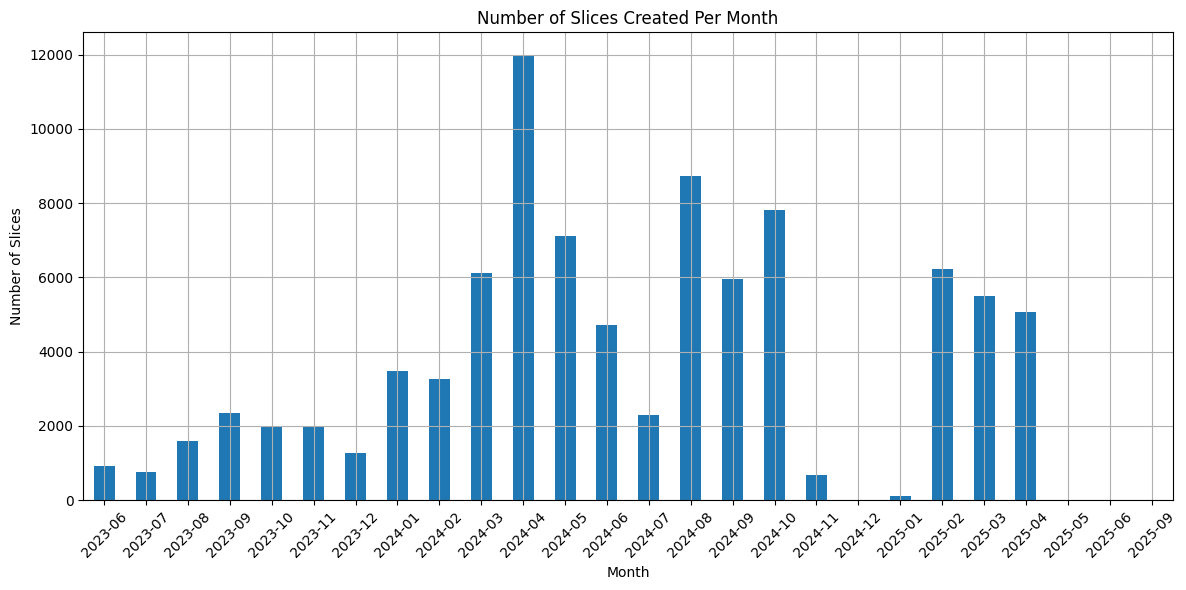

In [185]:
slices = response["data"]
print(f"Total slices: {len(slices)}")


# Step 3: Create DataFrame and process dates
df = pd.DataFrame(slices) 
print(f"Total slices: {len(df)}")

df['lease_start'] = pd.to_datetime(df['lease_start'], format="mixed", utc=True)
print(f"Total slices: {len(df)}")

print(df['lease_start'].isna().sum())  # How many missing dates


df['month'] = df['lease_start'].dt.to_period('M')  # '2025-04'

print(f"Total slices: {len(df)}")

monthly_counts = df.groupby('month').size().sort_index()
for month, count in monthly_counts.items():
    print(f"{month}: {count}")

# Step 6: Plot
monthly_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Slices Created Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Slices')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Active Slices per Month

/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_35045/4097902078.py:9: UserWarning: Converting to Period representation will drop timezone information.
  start_month = df['lease_start'].min().to_period('M').to_timestamp()
/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_35045/4097902078.py:10: UserWarning: Converting to Period representation will drop timezone information.
  end_month = df['lease_end'].max().to_period('M').to_timestamp()


2023-06: 909
2023-07: 783
2023-08: 1630
2023-09: 2392
2023-10: 2024
2023-11: 2055
2023-12: 1345
2024-01: 3515
2024-02: 3384
2024-03: 6146
2024-04: 12257
2024-05: 7396
2024-06: 5051
2024-07: 2510
2024-08: 8822
2024-09: 6071
2024-10: 8066
2024-11: 974
2024-12: 72
2025-01: 181
2025-02: 6373
2025-03: 6029
2025-04: 5926
2025-05: 662
2025-06: 487
2025-07: 475
2025-08: 460
2025-09: 336
2025-10: 103


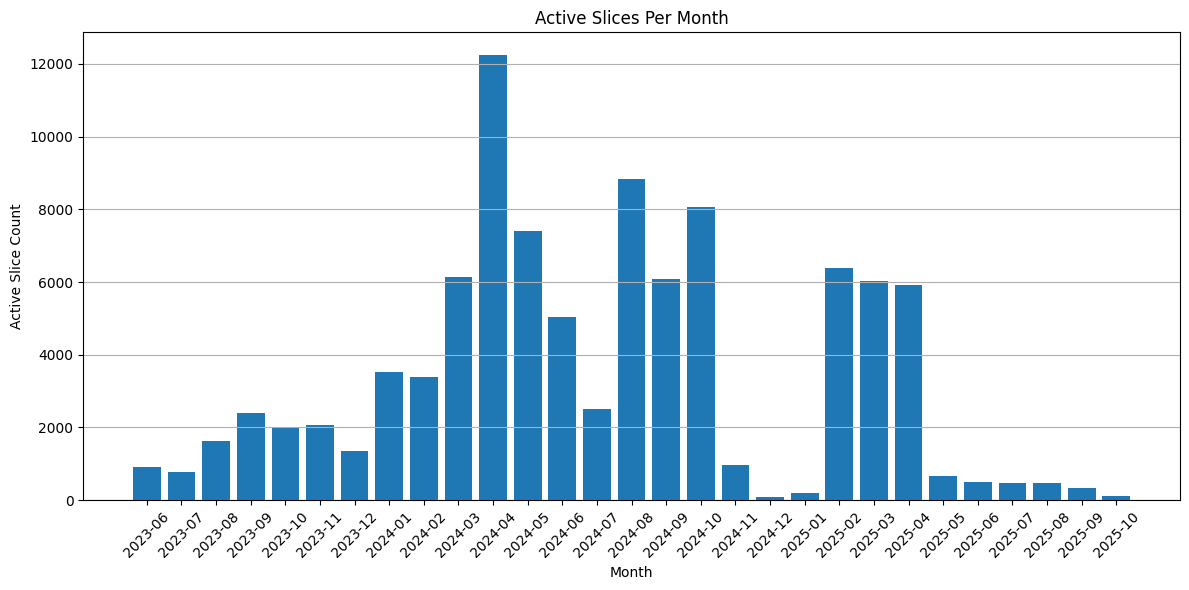

In [186]:
# Create DataFrame
df = pd.DataFrame(slices)

# Robust datetime parsing using 'mixed' format
df['lease_start'] = pd.to_datetime(df['lease_start'], format="mixed", utc=True)
df['lease_end'] = pd.to_datetime(df['lease_end'], format="mixed", utc=True)

# Generate monthly range
start_month = df['lease_start'].min().to_period('M').to_timestamp()
end_month = df['lease_end'].max().to_period('M').to_timestamp()
month_range = pd.date_range(start=start_month, end=end_month, freq='MS')

# Count active slices per month
active_counts = []
for month_start in month_range:
    month_start = month_start.tz_localize("UTC")
    month_end = (month_start + relativedelta(months=1)) - pd.Timedelta(seconds=1)
    active = df[(df['lease_start'] <= month_end) & (df['lease_end'] >= month_start)]
    active_counts.append(len(active))

for month, count in zip(month_range, active_counts):
    print(f"{month.strftime('%Y-%m')}: {count}")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(month_range.strftime('%Y-%m'), active_counts)
plt.xticks(rotation=45)
plt.title("Active Slices Per Month")
plt.xlabel("Month")
plt.ylabel("Active Slice Count")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


## Active Slices with SmartNICs

Total slices: 9365
Total slices: 9365
Total slices: 9365
2023-06: 184
2023-07: 66
2023-08: 189
2023-09: 163
2023-10: 118
2023-11: 302
2023-12: 278
2024-01: 256
2024-02: 252
2024-03: 347
2024-04: 585
2024-05: 484
2024-06: 387
2024-07: 318
2024-08: 2140
2024-09: 920
2024-10: 523
2024-11: 103
2024-12: 5
2025-01: 17
2025-02: 848
2025-03: 655
2025-04: 545
2025-05: 15
2025-06: 4
2025-07: 2


/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_35045/879317116.py:18: UserWarning: Converting to Period representation will drop timezone information.
  start_month = df['lease_start'].min().to_period('M').to_timestamp()
/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_35045/879317116.py:19: UserWarning: Converting to Period representation will drop timezone information.
  end_month = df['lease_end'].max().to_period('M').to_timestamp()


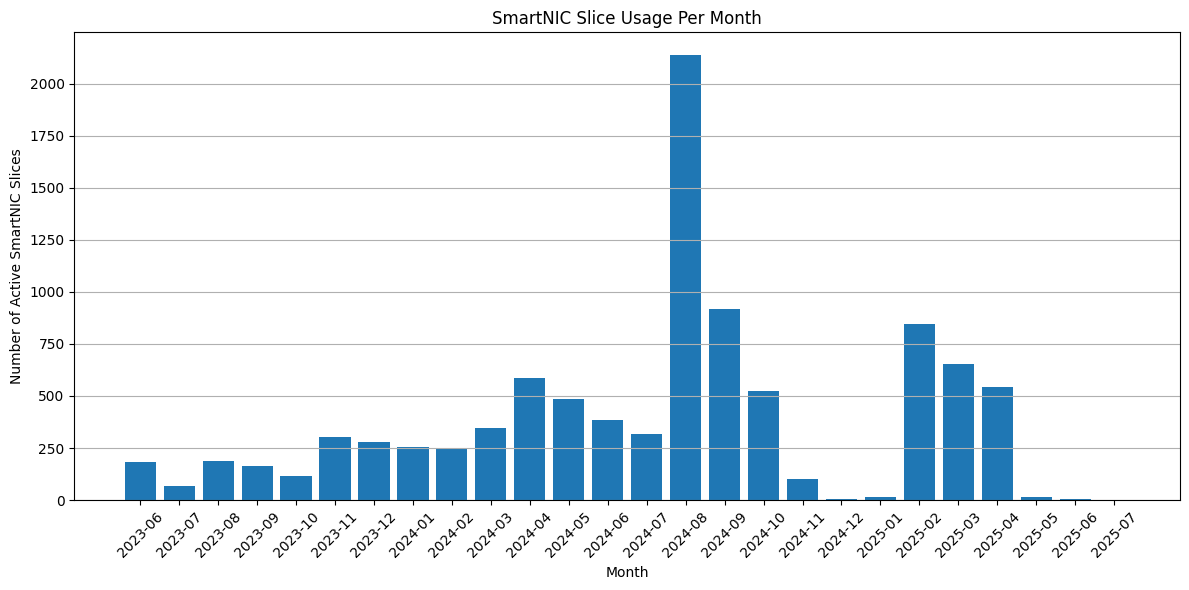

In [187]:
# Step 1: Fetch all slices that used SmartNICs
response = api.query_slices(component_type="SmartNIC", fetch_all=True, per_page=1000)
print(f"Total slices: {response.get('total')}")
slices = response["data"]
print(f"Total slices: {len(slices)}")


# Step 3: Create DataFrame and process dates
df = pd.DataFrame(slices) 
print(f"Total slices: {len(df)}")

# Step 2: Convert lease_start and lease_end to datetime (with UTC awareness)
# Robust datetime parsing using 'mixed' format
df['lease_start'] = pd.to_datetime(df['lease_start'], utc=True, format='mixed')
df['lease_end'] = pd.to_datetime(df['lease_end'], utc=True, format='mixed')

# Step 3: Define the month range for plotting
start_month = df['lease_start'].min().to_period('M').to_timestamp()
end_month = df['lease_end'].max().to_period('M').to_timestamp()
month_range = pd.date_range(start=start_month, end=end_month, freq='MS')

# Step 4: Count SmartNIC slices active in each month
smartnic_counts = []

for month_start in month_range:
    month_start = month_start.tz_localize("UTC")
    month_end = (month_start + relativedelta(months=1)) - pd.Timedelta(seconds=1)

    active_slices = df[
        (df['lease_start'] <= month_end) &
        (df['lease_end'] >= month_start)
    ]
    smartnic_counts.append(len(active_slices))

for month, count in zip(month_range, smartnic_counts):
    print(f"{month.strftime('%Y-%m')}: {count}")

# Step 5: Plot the results
plt.figure(figsize=(12, 6))
plt.bar(month_range.strftime('%Y-%m'), smartnic_counts)
plt.xticks(rotation=45)
plt.title("SmartNIC Slice Usage Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Active SmartNIC Slices")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


## Top 10 users for SmartNIC in a time range

In [188]:
import pandas as pd
from collections import defaultdict
from dateutil import parser

query_end = datetime.now(timezone.utc)
query_end = query_end.isoformat(timespec='milliseconds')

# NOTE: If no start time is provided, it will default to 30 days before the end time

# Load slivers with SmartNICs
slivers = api.query_slivers(end_time=query_end, component_type="SmartNIC", fetch_all=True, per_page=1000)["data"]

In [189]:
# {user_id: {"usage": float, "user_email": str, "project_id": str, "project_name": str}}
user_usage = {}

for s in slivers:
    user_id = s.get("user_id")
    user_email = s.get("user_email")
    project_id = s.get("project_id")
    project_name = s.get("project_name")
    lease_start = s.get("lease_start")
    lease_end = s.get("lease_end")
    smartnic_count = s.get("components", {}).get("total", 0)

    if not user_id or not lease_start or not lease_end:
        continue

    try:
        start = pd.to_datetime(lease_start, utc=True)
        end = pd.to_datetime(lease_end, utc=True)
        hours = max((end - start).total_seconds() / 3600.0, 0)
    except Exception:
        continue

    usage = smartnic_count * hours

    if user_id not in user_usage:
        user_usage[user_id] = {
            "smartnic_usage_hours": 0,
            "user_email": user_email,
            "project_id": project_id,
            "project_name": project_name
        }

    user_usage[user_id]["smartnic_usage_hours"] += usage

# Convert to DataFrame
usage_df = pd.DataFrame([
    {
        "user_id": uid,
        "user_email": info["user_email"],
        "project_id": info["project_id"],
        "project_name": info["project_name"],
        "smartnic_usage_hours": info["smartnic_usage_hours"]
    }
    for uid, info in user_usage.items()
])

# Sort and display top 10
top_users = usage_df.sort_values("smartnic_usage_hours", ascending=False).head(10)
print(top_users)


                                 user_id                       user_email  \
10  bc1ce1df-bf7e-43e9-881e-5f10fa5c7221              nshyamkumar@iit.edu   
2   78504735-b34f-42a8-be20-8e71d6acf13e            choueiri@email.sc.edu   
8   3461af49-64d7-4b74-a27d-f77fbdc8e62c                  IMahmud@lbl.gov   
0   e9db6486-f01a-4284-a3c1-335b17c3a825  maureen.c.dougherty@rutgers.edu   
1   4cfba0be-189b-46df-9a43-4ae5fcffda03                     kvasu@es.net   
7   c33d3fa7-ed56-4eb1-a8e3-2a1e5a500011                    rs75c@mst.edu   
3   91f5ecc3-16ff-4f09-95ac-dfeee0c3b1e3                   jbalcas@es.net   
4   d2d0e6f8-afc6-44ea-b580-195486fda319            elizalds@email.sc.edu   
13  0b9e6174-2901-412e-a15c-3e86b836b58b                  mfsada@ucsd.edu   
34  cb4d357a-f5cd-4a2e-b81c-541948f31d54        angelosdimoglis@gmail.com   

                              project_id  \
10  abe55161-26d9-434a-826a-4f9a655d0dde   
2   8eaa3ec2-65e7-49a3-8c09-e1761141a6ad   
8   1a0f06eb-75ea-42